### Abstract

We are interested to understand how people adjust their behaviour to the underlying temporal structure of changes. For this purpose we have modified a standard reversal learning task to include exploratory (epistemic) choices, which participants can use to learn the correct choice on the current trial. Participants were separated in two groups, each group exposed to different experimental conditions characterised by a different temporal structure of reversals.

In the first condition participants were exposed to regular (predictable) reversals for 800 trials and then to irregular sequence of reversals for 200 trials (same reversal rate but les predictable moment of reversals). In the second condition, the participant were first exposed to the irregular reversals (for 800 trials) and then to a sequence of regular reversal 200 trials.

Quanitfying probability of exploratory choices at each trial relative to the moment of reversals we can identify distinct characteristic responses of behaviour in two experimental conditions. This results suggest that people are sensitive to the temporal structure of the reversals (they can learn it) and that they use this structure for infering most likely moments of reversals, as reflected in the statistics of exploratory choices.

In [2]:
# load behavioural data
import numpy as np
from scipy import io
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from jupyterthemes import jtplot
jtplot.style(theme='onedork', context='paper', fscale=1.4, grid=False)

from stats import trials_until_correct, trials_until_explore, running_mean

import sys
import os
cwd = os.getcwd()

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn/tmp_present')])

df_res = pd.read_csv('../main/responses.csv').set_index('subject')
responses = df_res.values[:, :-1].T.astype(float)

outcomes = pd.read_csv('../main/outcomes.csv').set_index('subject').values.T.astype(float)
corrects = pd.read_csv('../main/correct_responses.csv').set_index('subject').values.T.astype(float)

states_and_rewards = io.loadmat('../main/states_and_rewards.mat')
Sirr = states_and_rewards['irregular']['S'][0, 0][:, 0] - 1
Oirr = states_and_rewards['irregular']['R'][0, 0]
Sreg = states_and_rewards['regular']['S'][0, 0][:, 0] - 1
Oreg = states_and_rewards['regular']['R'][0, 0]

ns_reg = (df_res['condition'] == 'regular').sum()   # number of subjects in the regular reversals group
ns_irr = (df_res['condition'] == 'irregular').sum()  # number of subjects in the irregular reversals group

nsub = responses.shape[-1]

ModuleNotFoundError: No module named 'jupyterthemes'

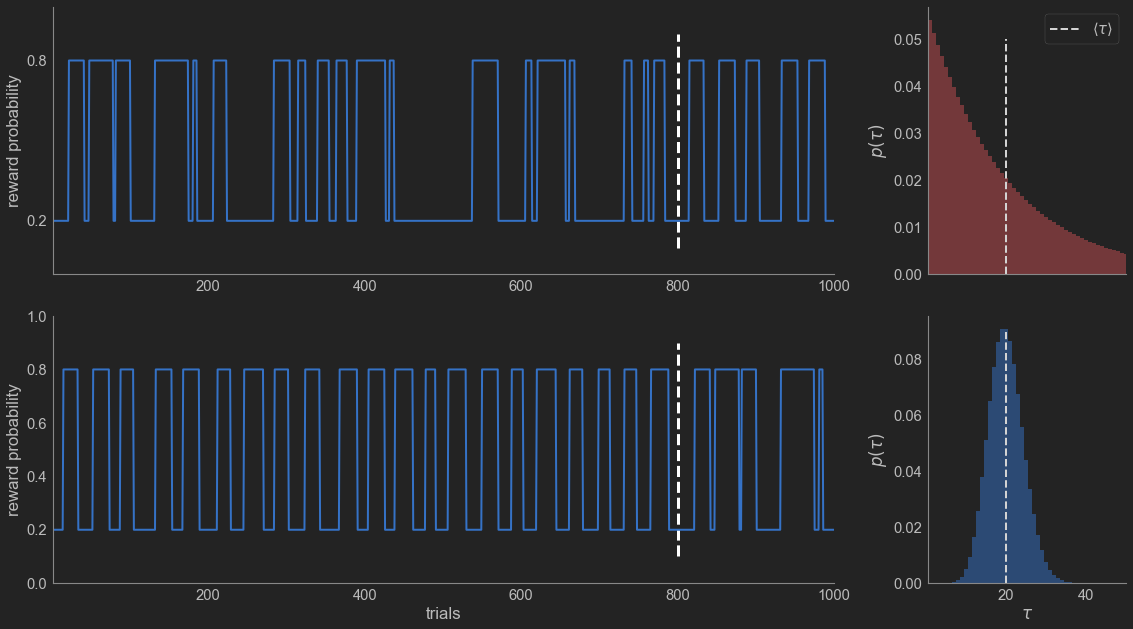

In [2]:
from scipy.special import loggamma
from jax import nn

fig, axes = plt.subplots(ncols=4, nrows=2, figsize=(16, 9), sharex=True)
gs = axes[0, 0].get_gridspec()
# remove the underlying axes
for ax in axes[:, :-1].flatten():
    ax.remove()
axbig1 = fig.add_subplot(gs[0, :-1])
axbig2 = fig.add_subplot(gs[1, :-1])

trials = np.arange(1, len(Sirr) + 1)

axbig1.plot(trials, .6 * Sirr + .2, lw=2)

axbig1.vlines(800, .1, .9, lw=3, color='w', linestyle='--')
axbig1.set_yticks([.2, .8])
axbig1.set_ylabel('reward probability')

axbig2.plot(trials, .6 * Sreg + .2, lw=2)
axbig2.vlines(800, .1, .9, lw=3, color='w', linestyle='--')
axbig2.set_ylabel('reward probability')
axbig2.set_xlabel('trials')

axbig1.set_xlim([1, len(Sirr)])
axbig1.set_ylim([.0, 1.])

axbig2.set_xlim([1, len(Sirr)])
axbig2.set_ylim([.0, 1.])

mu = 19
color = ['r', 'b']
d = np.arange(1., 51.)
for i, nu in zip(range(3), [1., 10000.]):
    k = d - 1
    lbinom = loggamma(k + nu) - loggamma(d) - loggamma(nu)
    delta = mu / (mu + nu)
    p0 = nn.softmax(lbinom + k * np.log(delta) + nu * np.log(1-delta), -1)
    axes[i, -1].bar(d, p0, alpha = .5, color=color[i], width=1)
    axes[i, -1].set_xlim([.5, 50])
    
axes[0, -1].vlines(20, 0, 0.05, color='lightgray', linestyle='--', label=r'$\langle \tau \rangle$', lw=2)
axes[1, -1].vlines(20, 0, 0.09, color='lightgray', linestyle='--', lw=2)
axes[0, -1].legend()

axes[0, -1].set_ylabel(r'$p(\tau)$')
axes[1, -1].set_ylabel(r'$p(\tau)$')
axes[1, -1].set_xlabel(r'$\tau$')

fig.align_labels()
fig.tight_layout()
sns.despine(fig)
fig.savefig('exp_rev_schedule.svg', transparent=True, dpi=300)

mean =  20.000002
mean =  19.999998
mean =  19.992985


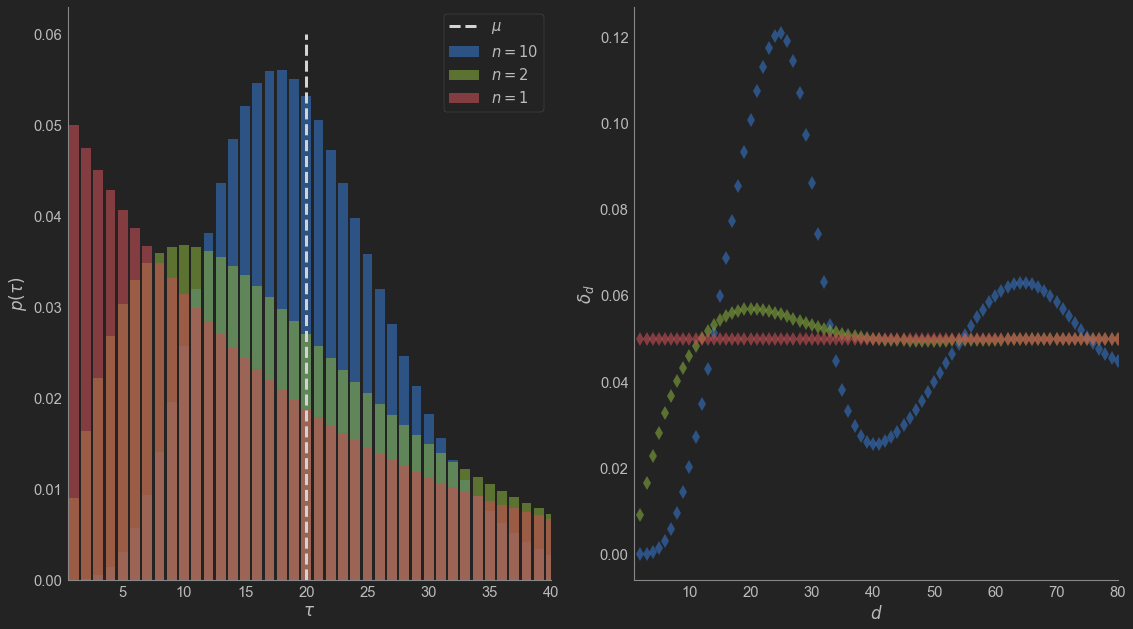

In [3]:
import jax.numpy as jnp
from jax.ops import index_update

def evolve_change_prob(S, D, T):
    # joint transition matrix
    tm=jnp.einsum('ijk,lk->iljk', S, D)
    
    #change probability
    dlt_tau = jnp.zeros(T-1)
    
    #joint_probability if the previous state was non reversal 
    #and the previous state duration follows the prior p0(d)
    joint = jnp.einsum('ijkl,l->ijk', tm, D[:, 0])[:, :, 0]
    
    #estimate change probability delta_tau at a future trial tau
    for tau in range(T - 1):
        marg_prob = joint.sum(1)
        if tau == 0:
            dlt_tau = index_update(dlt_tau, tau, marg_prob[1])
        else:
            dlt_tau = index_update(dlt_tau, tau, marg_prob[1, 0]/marg_prob[:, 0].sum(0))
            joint = joint.sum(-1)
        
        joint = jnp.einsum('ijkl,kl->ijk', tm, joint)
    
    return dlt_tau

d_max = 200 #maximal interval duration
d = jnp.arange(1., d_max+1., 1.)

ds = 2
R = (jnp.ones((ds, ds)) - jnp.eye(ds))/(ds-1)
S = jnp.concatenate([jnp.expand_dims(R, -1), jnp.eye(ds).reshape(ds, ds, 1).repeat(d_max-1, -1)], -1)

D = jnp.diag(jnp.ones(d_max-1), k=1)
fig, ax = plt.subplots(1, 2, figsize = (16, 9), tight_layout=True)

mu = 19
color = ['b', 'g', 'r']
labels = [r'$\sigma = \mu$', r'$\sigma = 10\mu$', r'$\sigma = (\mu-1)\mu$']
for i, phi in zip(range(3), jnp.array([10., 2., 1.])):
    k = d - 1
    lbinom = loggamma(k + phi) - loggamma(d) - loggamma(phi)
    delta = mu / (mu + phi)
    sig = jnp.sqrt(mu + mu**2/phi)
    p0 = nn.softmax( lbinom + k * jnp.log(delta) + phi * jnp.log(1-delta), -1)
    print('mean = ', jnp.sum(d*p0))
    D = index_update(D, (..., 0), p0)
    ax[0].bar(np.arange(d_max)+1, p0, alpha = 0.6, label = r'$n={}$'.format(int(phi)), color=color[i])
    T = 100
    ax[1].plot(np.arange(2, T+1, 1), evolve_change_prob(S, D, T), 'd', markersize=10, alpha=.6, label=labels[i], color=color[i], markeredgecolor='none')

ax[0].vlines(mu+1, 0, .06, 'lightgray', lw=3, linestyle='--', label=r'$\mu$')
ax[0].legend()
ax[0].set_xlim([.5,40])
ax[0].set_xlabel(r'$ \tau $')
ax[0].set_ylabel(r'$p( \tau )$')

ax[1].set_ylabel(r'$\delta_{d}$')
ax[1].set_xlabel(r'$d$')
ax[1].set_xlim([1,80])

sns.despine(fig)
fig.savefig('distribution.svg', bbox_inches='tight', transparent=True, dpi=300)

In [4]:
# remove subjects which did not generate exploratory responses
expl_subs = (responses == 2).sum(0) > 20
expl_sub_num = np.arange(nsub)[expl_subs]
nexpl_sub_num = np.arange(nsub)[~expl_subs]

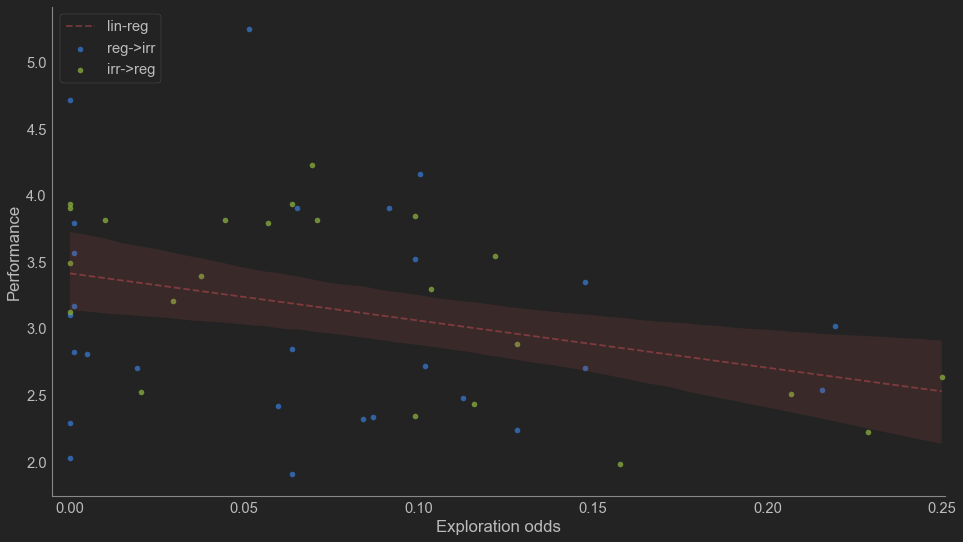

In [5]:
cutoff = 800
prob = np.nanmean(np.nan_to_num(corrects)[-cutoff:], -2)
df = pd.DataFrame({'performance': prob/(1 - prob)})

df['exploration'] = np.nanmean(responses[-cutoff:] == 2, -2)
df['ratio'] = df['exploration'] / (1 - df['exploration'])

df['condition'] = 'reg->irr'
df.loc[ns_reg:, 'condition'] = 'irr->reg'

fig, axes = plt.subplots(1, 1, figsize=(16, 9), sharey=True)
sns.regplot(x='ratio', y='performance', data=df.loc[df.condition == 'reg->irr'], ax=axes, fit_reg=False);
sns.regplot(x='ratio', y='performance', data=df.loc[df.condition == 'irr->reg'], ax=axes, fit_reg=False);
sns.regplot(x='ratio', y='performance', data=df, color='r', ax=axes, scatter_kws={'alpha': 0.}, line_kws={'linestyle': '--', 'alpha':.5});

axes.legend(['lin-reg', 'reg->irr', 'irr->reg'], loc=2)
sns.despine(fig)
axes.set_xlim([-.005, 0.251])
axes.set_ylabel('Performance')
axes.set_xlabel('Exploration odds')
fig.savefig('data_perf_expl.svg', bbox_inches='tight', transparent=True, dpi=300)

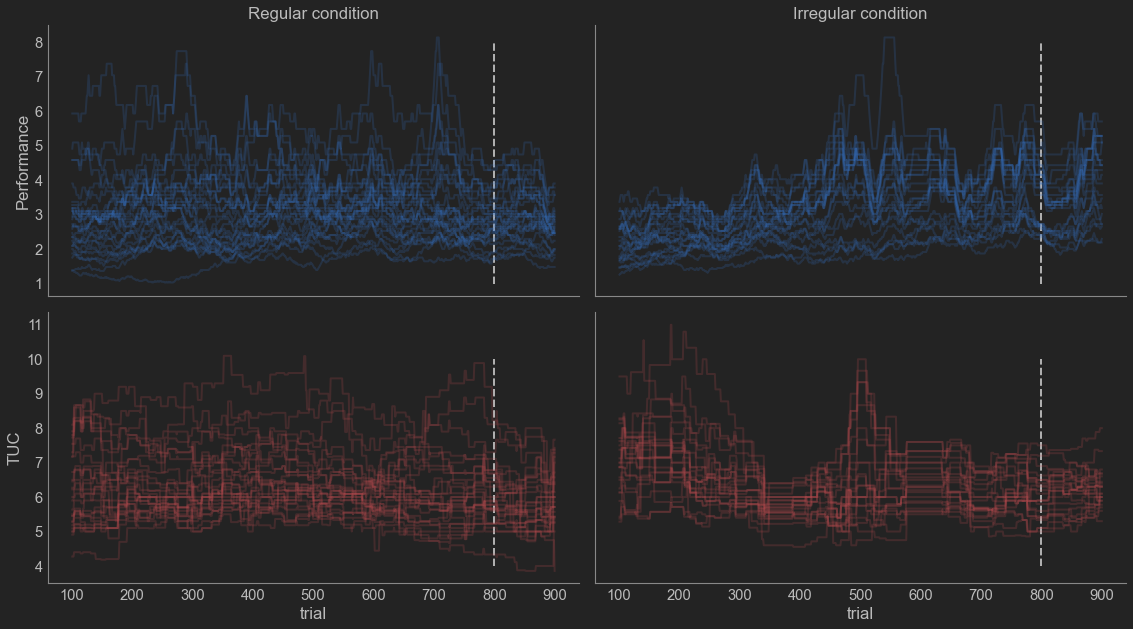

In [6]:
from stats import trials_until_correct, running_mean, performance

ws = 201
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')
trials = jnp.arange(101, 901)

states =  np.concatenate([Sreg[None].repeat(ns_reg, 0), Sirr[None].repeat(ns_irr, 0)], 0)
tuc = trials_until_correct(np.nan_to_num(corrects).T, states, τ=3)
rolling_tuc = running_mean(tuc, ws=ws)
rolling_perf = performance(np.nan_to_num(corrects), ws=ws)

axes[0, 0].plot(trials, rolling_perf[:ns_reg].T, color='b', lw=2, alpha=.2);
axes[0, 1].plot(trials, rolling_perf[ns_reg:].T, color='b', lw=2, alpha=.2);
axes[1, 0].plot(trials, rolling_tuc[:ns_reg].T, color='r', lw=2, alpha=.2);
axes[1, 1].plot(trials, rolling_tuc[ns_reg:].T, color='r', lw=2, alpha=.2);

for i in range(2):
    axes[0, i].vlines(800, 1, 8, color='lightgray', linestyle='--', lw=2, alpha=.8)
    axes[1, i].vlines(800, 4, 10, color='lightgray', linestyle='--', lw=2, alpha=.8)

# axes[0, 1].legend(loc=2, title='Model');

axes[0, 0].set_ylabel('Performance');
axes[1, 0].set_ylabel('TUC');
axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')
axes[1, 0].set_xlabel('trial')
axes[1, 1].set_xlabel('trial')

fig.tight_layout()
sns.despine(fig)
fig.savefig('invivo_comp_perf_tuc.svg', transparent=True, dpi=300)

In [33]:
fits = np.load('post_sample.npz', allow_pickle=True)
waic = fits['samples'].item()['waic']

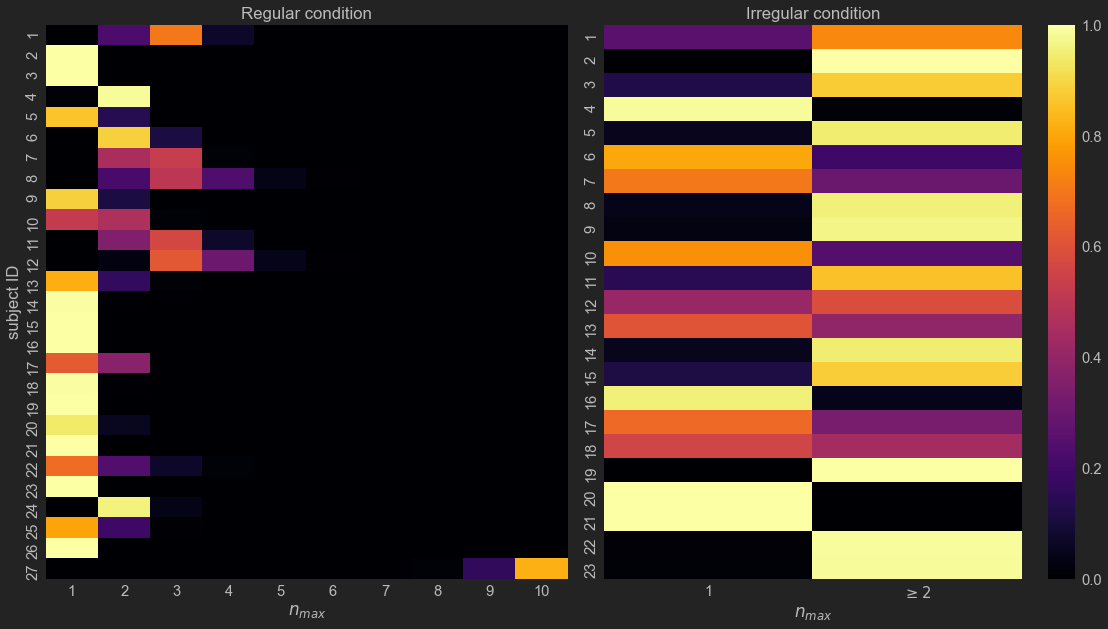

In [8]:
from jax.nn import softmax

fig, axes = plt.subplots(1, 2, figsize=(16, 9))

sns.heatmap(data=softmax(waic[:, :ns_reg], 0).T, vmin=0, vmax=1.0, cmap='inferno', ax=axes[0], xticklabels=range(1, 11), yticklabels= range(1, ns_reg + 1), cbar=False)
probs = softmax(waic[:, ns_reg:], 0)
data = np.concatenate([probs[:1], probs[1:].sum(0, keepdims=True)], 0)
sns.heatmap(data=data.T, vmin=0, vmax=1.0, cmap='inferno', ax=axes[1], xticklabels=[1, r'$\geq 2$'], yticklabels= range(1, ns_irr + 1))

axes[0].set_ylabel('subject ID');
axes[0].set_title('Regular condition')
axes[0].set_xlabel(r'$n_{max}$')
axes[1].set_xlabel(r'$n_{max}$')
axes[1].set_title('Irregular condition')
fig.tight_layout()
fig.savefig('data_model_comaprison.svg', transparent=True, dpi=300)

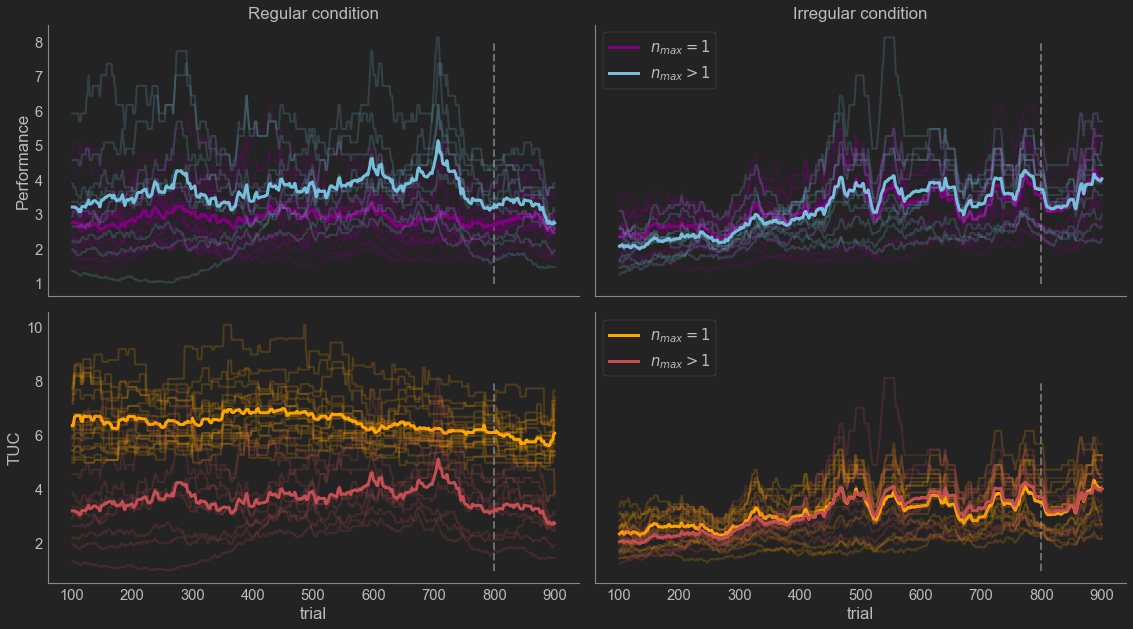

In [9]:
probs = softmax(waic, 0)
locs = probs.argmax(0) == 0

fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')
trials = jnp.arange(101, 901)

states =  np.concatenate([Sreg[None].repeat(ns_reg, 0), Sirr[None].repeat(ns_irr, 0)], 0)
tuc = trials_until_correct(np.nan_to_num(corrects).T, states, τ=3)
rolling_tuc = running_mean(tuc, ws=ws)
rolling_perf = performance(np.nan_to_num(corrects), ws=ws)

rp1 = rolling_perf[:ns_reg][locs[:ns_reg], :].T
axes[0, 0].plot(trials, rp1, color='purple', alpha=.2, lw=2);
axes[0, 0].plot(trials, rp1.mean(-1), color='purple', lw=3, label=r'$n_{max}=1$');

rp11 = rolling_perf[:ns_reg][~locs[:ns_reg], :].T
axes[0, 0].plot(trials, rp11, color='c', alpha=.2, lw=2);
axes[0, 0].plot(trials, rp11.mean(-1), color='c', lw=3, label=r'$n_{max}>1$');

rp2 = rolling_perf[ns_reg:][locs[ns_reg:], :].T
axes[0, 1].plot(trials, rp2, color='purple', alpha=.2, lw=2);
axes[0, 1].plot(trials, rp2.mean(-1), color='purple', lw=3, label=r'$n_{max}=1$');

rp22 = rolling_perf[ns_reg:][~locs[ns_reg:], :].T
axes[0, 1].plot(trials, rp22, color='c', alpha=.2, lw=2);
axes[0, 1].plot(trials, rp22.mean(-1), color='c', lw=3, label=r'$n_{max}>1$');

rl1 = rolling_tuc[:ns_reg][locs[:ns_reg], :].T
axes[1, 0].plot(trials, rl1, color='orange', alpha=.2, lw=2);
axes[1, 0].plot(trials, rl1.mean(-1), color='orange', lw=3, label=r'$n_{max}=1$');

rl11 = rolling_tuc[:ns_reg][~locs[:ns_reg], :].T
axes[1, 0].plot(trials, rp11, color='r', alpha=.2, lw=2);
axes[1, 0].plot(trials, rp11.mean(-1), color='r', lw=3, label=r'$n_{max}>1$');

rl2 = rolling_tuc[ns_reg:][locs[ns_reg:], :].T
axes[1, 1].plot(trials, rp2, color='orange', alpha=.2, lw=2);
axes[1, 1].plot(trials, rp2.mean(-1), color='orange', lw=3, label=r'$n_{max}=1$');

rl22 = rolling_tuc[ns_reg:][~locs[ns_reg:], :].T
axes[1, 1].plot(trials, rp22, color='r', alpha=.2, lw=2);
axes[1, 1].plot(trials, rp22.mean(-1), color='r', lw=3, label=r'$n_{max}>1$');

# axes[1, 0].plot(trials, rolling_tuc[:ns_reg].T, color='r', lw=2, alpha=.2);
# axes[1, 1].plot(trials, rolling_tuc[ns_reg:].T, color='r', lw=2, alpha=.2);

for i in range(2):
    axes[0, i].vlines(800, 1, 8, color='gray', linestyle='--', lw=2, alpha=.8)
    axes[1, i].vlines(800, 1, 8, color='gray', linestyle='--', lw=2, alpha=.8)

# axes[0, 1].legend(loc=2, title='Model');

axes[0, 1].legend(loc=2)
axes[1, 1].legend(loc=2)

axes[0, 0].set_ylabel('Performance');
axes[1, 0].set_ylabel('TUC');
axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')
axes[1, 0].set_xlabel('trial')
axes[1, 1].set_xlabel('trial')

fig.tight_layout()
sns.despine(fig)
fig.savefig('invivo_comp_perf_tuc_labeled.svg', transparent=True, dpi=300)

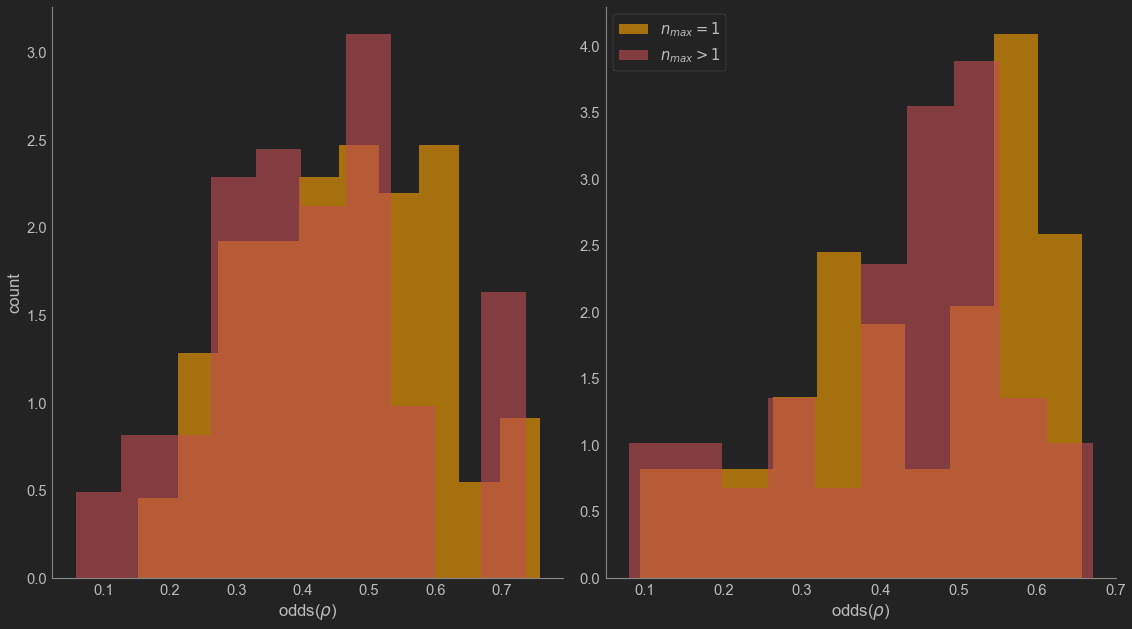

In [36]:
probs = softmax(waic, 0)
vals = probs.argmax(0)
expl_pref = np.stack([fits['samples'].item()[v+1]['prob'][..., i, -1] for i, v in enumerate(vals)])
expl_pref_odds = expl_pref/(1 - expl_pref)

fig, axes = plt.subplots(1, 2, figsize=(16, 9))

axes[0].hist(expl_pref_odds[:ns_reg][locs[:ns_reg], ::10].reshape(-1), label=r'$n_{max}=1$', color='orange', alpha=0.6, density=True);
axes[0].hist(expl_pref_odds[:ns_reg][~locs[:ns_reg], ::10].reshape(-1), label=r'$n_{max}>1$', color='r', alpha=0.6, density=True);

axes[1].hist(expl_pref_odds[ns_reg:][locs[ns_reg:], ::10].reshape(-1), label=r'$n_{max}=1$', color='orange', alpha=0.6, density=True);
axes[1].hist(expl_pref_odds[ns_reg:][~locs[ns_reg:], ::10].reshape(-1), label=r'$n_{max}>1$', color='r', alpha=0.6, density=True);

axes[1].legend()
axes[0].set_ylabel('count')
axes[0].set_xlabel(r'odds($\rho$)')
axes[1].set_xlabel(r'odds($\rho$)')

sns.despine(fig)
fig.tight_layout()
fig.savefig('rho_odds.svg', transparent=True, dpi=300)

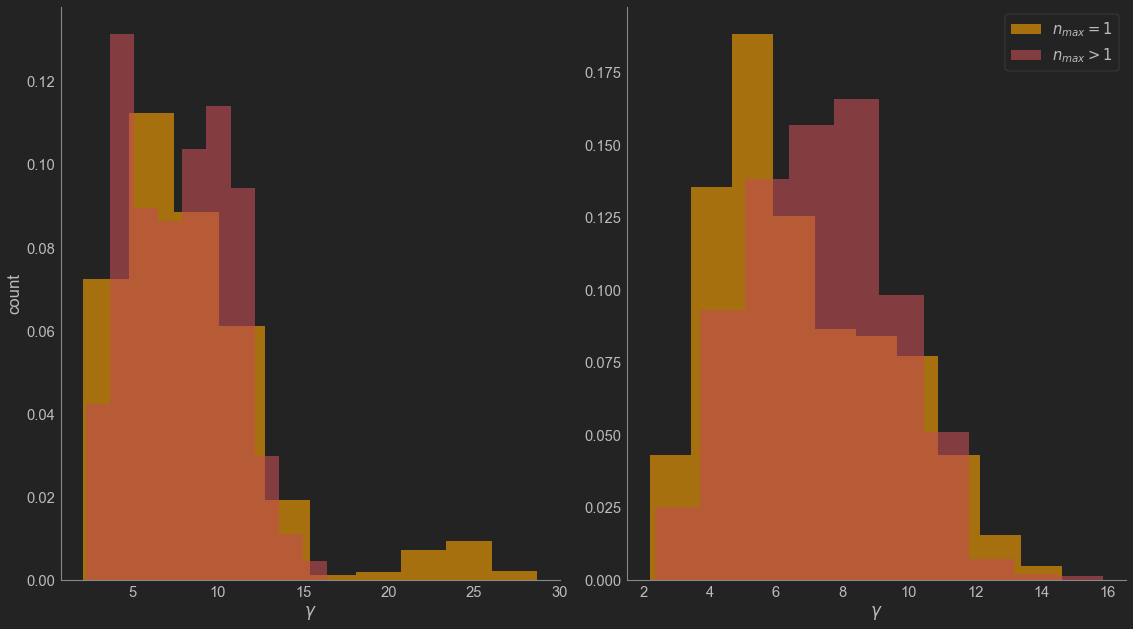

In [26]:
probs = softmax(waic, 0)
vals = probs.argmax(0)
gammas = np.stack([fits['samples'].item()[v+1]['gamma'][..., i] for i, v in enumerate(vals)])

fig, axes = plt.subplots(1, 2, figsize=(16, 9))

axes[0].hist(gammas[:ns_reg][locs[:ns_reg], ::10].reshape(-1), label=r'$n_{max}=1$', color='orange', alpha=0.6, density=True);
axes[0].hist(gammas[:ns_reg][~locs[:ns_reg], ::10].reshape(-1), label=r'$n_{max}>1$', color='r', alpha=0.6, density=True);

axes[1].hist(gammas[ns_reg:][locs[ns_reg:], ::10].reshape(-1), label=r'$n_{max}=1$', color='orange', alpha=0.6, density=True);
axes[1].hist(gammas[ns_reg:][~locs[ns_reg:], ::10].reshape(-1), label=r'$n_{max}>1$', color='r', alpha=0.6, density=True);

axes[1].legend()
axes[0].set_ylabel('count')
axes[0].set_xlabel(r'$\gamma$')
axes[1].set_xlabel(r'$\gamma$')

sns.despine(fig)
fig.tight_layout()
fig.savefig('gammas_labeled.svg', transparent=True, dpi=300)

In [7]:
from scipy import io
# load experiment and generate observations
data = io.loadmat('../main/states_and_rewards.mat')
Sirr = data['irregular']['S'][0, 0][:, 0] - 1
Oirr = data['irregular']['R'][0, 0]
Sreg = data['regular']['S'][0, 0][:, 0] - 1
Oreg = data['regular']['R'][0, 0]

runs = 1

outcomes1 = jnp.concatenate([(Oreg[:, None].repeat(runs, -2) + 1)//2, 
                            (Oirr[:, None].repeat(runs, -2) + 1)//2], -2)
outcomes2 = jnp.concatenate([Sreg[:, None].repeat(runs, -1) + 2, 
                             Sirr[:, None].repeat(runs, -1) + 2], -1)[..., None]

outcomes = jnp.concatenate([outcomes1, outcomes2], -1)

subs = jnp.array(range(2 * runs))
def process(t, responses):
    return outcomes[t, subs, responses]

In [8]:
# agent modelimport jax.numpy as jnp
from jax import nn, random, lax, vmap, ops
from jax.scipy.special import digamma
from scipy.special import binom
from opt_einsum import contract, contract_expression

sys.path.append(cwd[:-len('befit/examples/temp_rev_learn/tmp_present/')])

def einsum(equation, *args):
    return contract(equation, *args, backend='jax')

vdiag = vmap(lambda v: jnp.diag(v, k=0))
voffd = vmap(lambda v: jnp.diag(v, k=1))
def log(x):
    return jnp.nan_to_num(jnp.log(x))

class Agent(object):
    def __init__(self, N, nu=1):
        self.N = N
        self.nu = nu
        
        self.__make_transition_matrices()
        self.__set_prior()
        
    def __make_transition_matrices(self):
        nu = jnp.arange(1, self.nu + 1)
        mu = jnp.arange(4., 40., 1.)
        p = mu[..., None]/(nu[None] + mu[..., None])
        
        j = jnp.tril(jnp.arange(1, self.nu + 1)[None].repeat(self.nu, 0))
        bnm = binom(nu[..., None], jnp.tril(j-1))
        p1 = p[..., None] ** jnp.tril((nu[..., None] - j + 1))
        p2 = (1 - p[..., None])**jnp.tril(j - 1)
        pi =  jnp.tril(bnm * p1 * p2)
        pi = jnp.concatenate([pi, 1 - pi.sum(-1, keepdims=True)], -1)
        
        # phase transition matrix for different models m, f_t| f_{t+1}
        p_ff = []
        for i in range(self.nu):
            vp = p[..., i:i + 1].repeat(i + 1, -1)
            tmp = jnp.concatenate([vdiag(vp) + voffd(1 - vp[..., :-1]), jnp.zeros((p.shape[0], i + 1, self.nu - i - 1))], -1)
            tmp = jnp.concatenate([tmp, 1 - tmp.sum(-1, keepdims=True)], -1)
            tmp = jnp.concatenate([tmp, jnp.ones((p.shape[0], self.nu - i - 1, self.nu + 1))/(self.nu + 1)], -2)
            tmp = jnp.concatenate([tmp, pi[:, i:i+1]], -2)
            p_ff.append(tmp)
        
        self.p_mff = jnp.stack(p_ff, -3).reshape(-1, self.nu + 1, self.nu + 1)
        
        # state transition matrix f_t, j_t| j_{t+1}
        p_fjj = jnp.zeros((self.nu + 1, 2, 2))
        p_fjj = ops.index_add(p_fjj, ops.index[-1, :, 1], 1.)
        p_fjj = ops.index_add(p_fjj, ops.index[:-1, :, 0], 1.)
        
        p_jcc = jnp.stack([jnp.eye(2), (jnp.ones((2, 2)) - jnp.eye(2))], 0)

        self.p_fcc = einsum('jcz,fj->fcz', p_jcc, p_fjj[:, 0])
        
    def __set_prior(self, a=6., b=32.):
        prior_mf = self.p_mff[:, -1]
        M = prior_mf.shape[0]
        prior_m = jnp.ones(M)/M
        prior_fm = (prior_mf * prior_m[:, None]).T
        prior_c = jnp.ones(2)/2

        pars = jnp.array([
            [[a, b, 1, 1], [b, a, 1, 1]],
            [[b, a, 1, 1], [a, b, 1, 1]],
            [[1, 1, 1000., 1], [1, 1, 1, 1000.]]
        ])[None].repeat(self.N, 0)
        
        probs = einsum('c,fm->cfm', prior_c, prior_fm)[None].repeat(self.N, 0)
        self.prior = (probs, pars)
        
    
    def __par_efe(self, p_c, params, omega, U):
        p_aco = params/params.sum(-1, keepdims=True)
        q_ao = einsum('...aco,...c->...ao', p_aco, p_c)
    
        KL_a =  - omega * jnp.sum(q_ao * U, -1) + jnp.sum(q_ao * log(q_ao), -1)
    
        H_ac = - (p_aco * digamma(params)).sum(-1) + digamma(params.sum(-1) + 1)
        H_a = einsum('...c,...ac->...a', p_c, H_ac)
    
        return KL_a + H_a
    
    def logits(self, beliefs, gamma, omega, U):
        p_cfm, params = beliefs

        # expected surprisal based action selection
        p_c = einsum('...cfm->...c', p_cfm)

        S_a = self.__par_efe(p_c, params, omega, U)

        return - gamma * ( S_a - S_a.min(-1, keepdims=True))

    def action_selection(self, rng_key, beliefs, gamma=1e3, omega=1., U=jnp.array([-1., 1., 0., 0.])):
        # sample choices
        return random.categorical(rng_key, self.logits(beliefs, gamma, omega, U))

    # parametric learning and inference
    def learning(self, observations, responses, prior):
        p_cfm, params = prior
        obs = jnp.eye(4)[observations]

        p_aco = params/params.sum(-1, keepdims=True)

        p_c = einsum('nco,no->nc', p_aco[jnp.arange(self.N), responses], obs)
        
        post = einsum('nc,ncfm->ncfm', p_c, p_cfm)
        norm = post.reshape(post.shape[:-3] + (-1,)).sum(-1)[..., None, None, None]
        post = post/norm

        resp = jnp.eye(3)[responses]
        post_c = post.reshape(post.shape[:-2] + (-1,)).sum(-1)

        params_new = params + einsum('na,nc,no->naco', resp, post_c, obs)
        pred = einsum('fcz,mfg,ncfm->nzgm', self.p_fcc, self.p_mff, post)

        return (pred, params_new)

In [9]:
# POMDP simulator
def simulator(process, agent, seed=0, **model_kw):
    def sim_fn(carry, t):
        rng_key, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = agent.action_selection(_rng_key, prior, **model_kw)
        
        outcomes = process(t, choices)
        
        posterior = agent.learning(outcomes, choices, prior)
                
        return (rng_key, posterior), {'outcomes': outcomes, 
                                      'choices': choices,
                                      'beliefs': prior}
    
    rng_key = random.PRNGKey(seed)
    _, sequence = lax.scan(sim_fn, (rng_key, agent.prior), jnp.arange(len(outcomes)))
    sequence['outcomes'].block_until_ready()
    
    return sequence

In [ ]:
N = outcomes.shape[-2]
sequences = {}
for nu in [1, 10]:
    agent = Agent(N, nu)
    sequences[nu] = simulator(process, agent, U=jnp.array([-1., 1., -.5, -.5]))

In [ ]:
from stats import trials_until_correct, running_mean, performance

ws = 201
fig, axes = plt.subplots(2, 2, figsize=(16, 9), sharex=True, sharey='row')
trials = jnp.arange(101, 901)

for nu in [1, 10]:
    corr = outcomes[..., -1] - 2 == sequences[nu]['choices']
    corr[sequences[nu]['choices']] = jnp.nan
    states =  outcomes[..., -1] - 2
    tuc = trials_until_correct(jnp.nan_to_num(corr).T, states.T, τ=3)
    rolling_tuc = running_mean(tuc, ws=ws)
    rolling_perf = performance(corr, ws=ws)
    
    for i in range(2):
        axes[0, i].plot(trials, rolling_perf[i], lw=3, label=r'$n_{max}=$'+r'{}'.format(nu), alpha=.8);
        axes[0, i].vlines(800, 0, 12, color='w', linestyle='--', lw=2, alpha=.8)
        axes[1, i].plot(trials, rolling_tuc[i], lw=3, label=r'$n_{max}=$'+r'{}'.format(nu), alpha=.8);
        axes[1, i].vlines(800, 4, 7.5, color='w', linestyle='--', lw=2, alpha=.8)

axes[0, 1].legend(loc=2, title='Model');

axes[0, 0].set_ylabel('Performance');
axes[1, 0].set_ylabel('TUC');
axes[0, 0].set_title('Regular condition')
axes[0, 1].set_title('Irregular condition')
axes[1, 0].set_xlabel('trial')
axes[1, 1].set_xlabel('trial')

fig.tight_layout()
sns.despine(fig)
fig.savefig('insilico_comp_perf_tuc.svg', transparent=True, dpi=300)

In [ ]:
# POMDP simulator
def simulator(process, agent, seed=0, **model_kw):
    def sim_fn(carry, t):
        rng_key, prior = carry
        
        rng_key, _rng_key = random.split(rng_key)
        choices = agent.action_selection(_rng_key, prior, **model_kw)
        
        outcomes = process(t, choices)
        
        posterior = agent.learning(outcomes, choices, prior)
                
        return (rng_key, posterior), {'outcomes': outcomes, 
                                      'choices': choices,
                                      'beliefs': prior}
    
    rng_key = random.PRNGKey(seed)
    _, sequence = lax.scan(sim_fn, (rng_key, agent.prior), jnp.arange(len(outcomes)))
    sequence['outcomes'].block_until_ready()
    
    return sequence

In [5]:
nsub = reg_res.shape[-1]
reg_perf, reg_expl = get_reversal_statistics(reg_res, reg_corr, Sreg, nsub)

nsub = irr_res.shape[-1]
irr_perf, irr_expl = get_reversal_statistics(irr_res, irr_corr, Sirr, nsub)

t = np.arange(-10, 10)

## Prior predictive check based on mean performance

In [4]:
trials = 1000
def get_reversal_statistics(responses, corrects, states, nsub, delta=200):

    A = responses.T == 2
    C = corrects.T

    reversal = np.abs(np.diff(states.flatten())).astype(bool)
    trials = np.arange(1, 1000)[reversal]
    perf = {}
    expl = {}
    for t in trials:
        block = np.long(np.floor(t/delta))
        perf.setdefault(block, [])
        perf[block].append(C[:,t-10:t+10])
        
        expl.setdefault(block, [])
        expl[block].append(A[:,t-10:t+10])
        
    for block in expl:
        perf[block] = np.nanmean(np.stack(perf[block]), 0)
        expl[block] = np.nanmean(np.stack(expl[block]), 0)
    
    return perf, expl

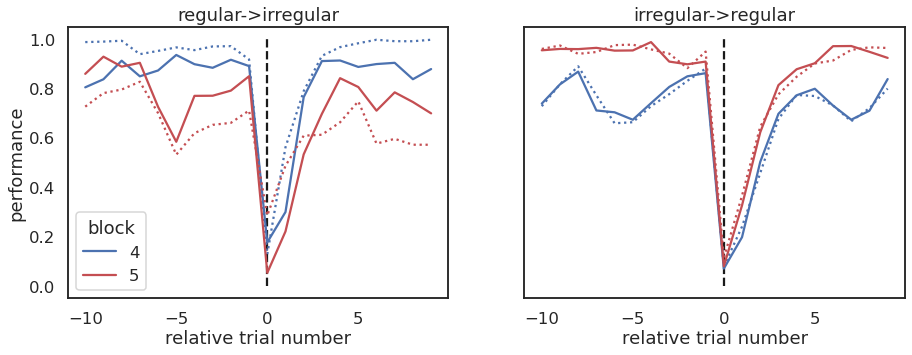

In [14]:
# plot superimposed behavioural and simulated response data
fig, axes = plt.subplots(1, 2, figsize=(15,5), sharey=True)
color = ['b', 'r']
for block in range(3,5):
    axes[0].plot(t, np.mean(np.vstack(reg_perf[block]), 0), label=block+1, color=color[block-3])
    axes[0].plot(t, np.mean(np.vstack(reg_perf1[block]), 0), ':', color=color[block-3])

    axes[1].plot(t, np.mean(np.vstack(irr_perf[block]), 0), color=color[block-3])
    axes[1].plot(t, np.mean(np.vstack(irr_perf2[block]), 0), ':', color=color[block-3])

axes[0].legend(title='block');
axes[0].vlines(0, 0., 1., 'k', linestyle='--');
axes[1].vlines(0, 0., 1., 'k', linestyle='--');
axes[0].set_xlabel('relative trial number');
axes[1].set_xlabel('relative trial number');
axes[0].set_title('regular->irregular');
axes[1].set_title('irregular->regular');
axes[0].set_ylabel('performance')
fig.savefig('performance_trial.svg', bbox_inches='tight', transparent=True, dpi=300)